References: 
https://www.kaggle.com/ratan123/start-from-here-disaster-tweets-eda-basic-model

In [2]:
!pip install spellchecker
! python -m pip install pyspellchecker
import pandas as pd
import numpy as np
import keras
import nltk
import string
import re
nltk.download('punkt')

from wordcloud import STOPWORDS
from google.colab import drive
from nltk import word_tokenize, sent_tokenize
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint 

     |████████████████████████████████| 3.9MB 4.6MB/s 
  Created wheel for spellchecker: filename=spellchecker-0.4-cp36-none-any.whl size=3966515 sha256=010f03296a52351a107bd4ca64310ef1f5e05ec34037b1c50e1adfccd8677cf2
  Stored in directory: /root/.cache/pip/wheels/a2/e6/ad/28ab959cba7100f5c562a3d1711cd34b630734d241c4e1bd40
  Created wheel for inexactsearch: filename=inexactsearch-1.0.2-cp36-none-any.whl size=7113 sha256=502594d219623a2297bc2626352c2dad09e78a97f5072f0af040b97ef28d54da
  Stored in directory: /root/.cache/pip/wheels/58/e0/c1/e3fed0e9fd1a3708bc91870fb0ba30ef88527540006763674b
  Created wheel for soundex: filename=soundex-1.1.3-cp36-none-any.whl size=8863 sha256=980f64f4f816e0fea1350a615457ef255127187c0fb1db9fefd9f63cabc331c5
  Stored in directory: /root/.cache/pip/wheels/b5/bb/e6/9a4b6be56c40aa707509bddaf6d414187461ded9db7a25a41a
  Created wheel for silpa-common: filename=silpa_common-0.3-cp36-none-any.whl size=8453 sha256=5bfba22d768bf5e5dfbc08c7127c3d9e51e4ea5c9d92fca68b

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
cd /content/drive/My Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [310]:
train_df = pd.read_csv('bert_output/train.csv')
test_df = pd.read_csv('bert_output/test.csv')
train_df.text.head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [279]:
bert_output = np.load('bert_output/bert-embeddings-train.npy')
bert_output_test = np.load('bert_output/bert-embeddings-test.npy')
bert_output.shape

(7613, 768)

In [311]:
def untokenize(words):
    """Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .', '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
        "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

def decontracted(phrase):
    """Convert contractions like "can't" into "can not"
    """
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    #phrase = re.sub(r"n't", " not", phrase) # resulted in "ca not" when sentence started with "can't"
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

nltk.download('wordnet')
from nltk.stem import PorterStemmer,WordNetLemmatizer
wl=WordNetLemmatizer()
ps=PorterStemmer()
sp=stopwords.words('english')
def clean_text(tweets):
    final_tmp=[]
    for tweet in tweets:
        #lower and remove punctuation
        tweet=tweet.translate(str.maketrans('','',string.punctuation)).lower()
        
        #Remove Hyperlinks
        tweet=re.sub(r'http\S+','',tweet)
        
        #Remove numbers and words containing numbers
        tweet=' '.join([i for i in tweet.split() if i.isalpha()])
        
        #Normalize words
        tweet=' '.join(wl.lemmatize(i,pos='a') for i in tweet.split())
        
        #Now stop words
        tweet=' '.join(i for i in tweet.split() if i not in sp)
        
        final_tmp.append(tweet)
    return final_tmp


# train_df['text'] = clean_text(train_df['text'])
# test_df['text'] = clean_text(test_df['text'])
train_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

In [0]:
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}

def unslang(text):
    """Converts text like "OMG" into "Oh my God"
    """
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text
    
def is_slang(text):
    if text.upper() in slang_abbrev_dict.keys():
        return True
    return False

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def is_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    if emoji_pattern.match(text):
        return True
    return False

In [0]:
def clean(reg_exp, text):
    text = re.sub(reg_exp, " ", text)

    # replace multiple spaces with one.
    text = re.sub('\s{2,}', ' ', text)

    return text

def remove_urls(text):
    text = clean(r"http\S+", text)
    text = clean(r"www\S+", text)
    text = clean(r"pic.twitter.com\S+", text)

    return text

In [0]:
def clean_all(t):
    # first do bulk cleanup on tokens that don't depend on word tokenization
    # remove xml tags
    t = clean(r"<[^>]+>", t)
    t = clean(r"&lt;", t)
    t = clean(r"&gt;", t)
    # remove URLs
    # t = remove_urls(t)
    # https://stackoverflow.com/a/35041925
    # replace multiple punctuation with single. Ex: !?!?!? would become ?
    t = clean(r'[\?\.\!]+(?=[\?\.\!])', t)
    # t = remove_emoji(t)
    # expand common contractions like "I'm" "he'll"
    t = decontracted(t)
    # now remove/expand bad patterns per word
    words = word_tokenize(t)
    clean_words = []
    for w in words:
        # normalize punctuation
        w = re.sub(r'&', 'and', w)
        # expand slang like OMG = Oh my God
        w = unslang(w)        
        clean_words.append(w)
    # join the words back into a full string
    t = untokenize(clean_words)
    # finally, remove any non ascii and special characters that made it through
    t = clean(r"[^A-Za-z0-9\.\'!\?,\$]", t)
    return t

In [276]:
# train_df['clean_text'] = train_df['text'].apply(lambda x: clean_all(x))
# test_df['clean_text'] = test_df['text'].apply(lambda x: clean_all(x))
# train_df['text'].iloc[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [0]:
spell = SpellChecker()
def typos(text):
    misspelled_words = spell.unknown(text.split())
    return misspelled_words

In [312]:
train_df['length_tweet'] =  train_df['text'].apply(lambda x: len(x))
test_df['length_tweet'] = test_df['text'].apply(lambda x: len(x))
train_df.head()

id keyword  ... target length_tweet
0   1     NaN  ...      1           69
1   4     NaN  ...      1           38
2   5     NaN  ...      1          133
3   6     NaN  ...      1           65
4   7     NaN  ...      1           88

[5 rows x 6 columns]

In [313]:
# train_df['length_tweet'] = [len(str(x)) for x in train_df['text'] if x!= 'NaN']

pivot = pd.pivot_table(train_df, values='length_tweet', index=['target'], aggfunc=np.mean)
pivot

length_tweet
target              
0          95.706817
1         108.113421

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
-Number of characters in tweets
-Number of tweets with hashtags: 7613
-- Hashtag distribution in positive samples 
            Frequency
Word                 
news               56
hiroshima          22
earthquake         19
hot                13
prebreak           13
best               13
japan              11
india              10
yyc                10
breaking            9
worldnews           9
world               9
isis                9
sismo               9
abstorm             9
islam               9
disaster            8
wildfire            8
terrorism           8
fukushima           8
-- Hashtag distribution in negative samples 
              Frequency
Word                   
nowplaying           21
news                 20
hot                  18
prebreak             17
best                 17
gbbo                 14
jobs                 14
islam                

Frequency
Word                   
nowplaying           21
news                 20
hot                  18
prebreak             17
best                 17
gbbo                 14
jobs                 14
islam                14
job                  12
hiring               10
fashion               9
edm                   8
dnb                   8
beyhive               8
directioners          8
emmerdale             8
rt                    7
dubstep               7
trapmusic             7
dance                 7

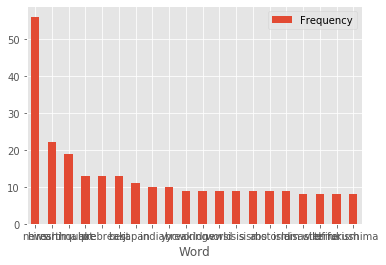

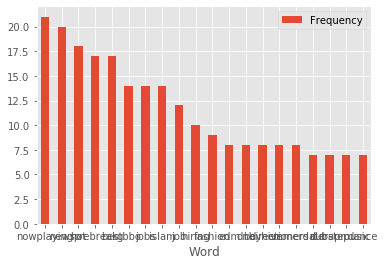

In [314]:

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english')) 

stop.add(',')
import matplotlib
def show_word_distrib(target=1, field="text"):
    txt = train_df[train_df['target']==target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stop) 
    
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)
    matplotlib.style.use('ggplot')

    rslt.plot.bar(rot=0)
    return rslt
    
print("-Number of characters in tweets")

def find_hashtags(tweet):
    return ", ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or None

def add_hashtags(train_df):
    from sklearn.feature_extraction.text import CountVectorizer
    
    train_df['hashtag'] = train_df["text"].apply(lambda x: find_hashtags(x))
    train_df['hashtag'].fillna(value="no", inplace=True)

    test_df['hashtag'] = test_df["text"].apply(lambda x: find_hashtags(x))
    test_df['hashtag'].fillna(value="no", inplace=True)
    
    return train_df, test_df
    
top_N = 20

train_df,test_df = add_hashtags(train_df)
_l = len([v for v in train_df.hashtag.values if isinstance(v, str)])
print("-Number of tweets with hashtags: {}".format(_l))
print("-- Hashtag distribution in positive samples ")
show_word_distrib(target=1, field="hashtag")

print("-- Hashtag distribution in negative samples ")
show_word_distrib(target=0, field="hashtag")

In [315]:
top_N = 20
target = 1
field="hashtag"
txt = train_df[train_df['target']==target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stop) 

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt.index

Index(['news', 'hiroshima', 'earthquake', 'hot', 'prebreak', 'best', 'japan',
       'india', 'yyc', 'breaking', 'worldnews', 'world', 'isis', 'sismo',
       'abstorm', 'islam', 'disaster', 'wildfire', 'terrorism', 'fukushima'],
      dtype='object', name='Word')

In [316]:
hot_words = ['hiroshima', 'earthquake', 'hot', 'prebreak',
       'india', 'breaking', 'worldnews', 'world', 'isis', 'sismo',
       'abstorm', 'islam', 'disaster', 'wildfire', 'terrorism', 'fukushima','attack','bomb',
        'explosion','fire', 'rain', 'tornado' , 'storm', 'murder', 'killing', 'calamity', 'catastrophe', 'collapse',
       'crash', 'emergency', 'failure']

train_df['word_tokenized'] = train_df['text'].apply(lambda x: word_tokenize(x))
test_df['word_tokenized'] = test_df['text'].apply(lambda x: word_tokenize(x))
# train_df['hot_word'] = train_df['word_tokenized'].apply(lambda x: [i in hot_words for i in train_df['word_tokenized']] )
train_df.head()

id  ...                                     word_tokenized
0   1  ...  [Our, Deeds, are, the, Reason, of, this, #, ea...
1   4  ...   [Forest, fire, near, La, Ronge, Sask, ., Canada]
2   5  ...  [All, residents, asked, to, 'shelter, in, plac...
3   6  ...  [13,000, people, receive, #, wildfires, evacua...
4   7  ...  [Just, got, sent, this, photo, from, Ruby, #, ...

[5 rows x 8 columns]

In [317]:
train_df['is_hot_word'] = train_df['word_tokenized'].apply(lambda x: len(set(x) & set(hot_words)) )
test_df['is_hot_word'] = test_df['word_tokenized'].apply(lambda x: len(set(x) & set(hot_words)) )

# train_df['is_hot_word'].value_counts()
# 0    7165
# 1     394
# 3      30
# 2      24
train_df.head(5)

id keyword  ...                                     word_tokenized is_hot_word
0   1     NaN  ...  [Our, Deeds, are, the, Reason, of, this, #, ea...           1
1   4     NaN  ...   [Forest, fire, near, La, Ronge, Sask, ., Canada]           1
2   5     NaN  ...  [All, residents, asked, to, 'shelter, in, plac...           0
3   6     NaN  ...  [13,000, people, receive, #, wildfires, evacua...           0
4   7     NaN  ...  [Just, got, sent, this, photo, from, Ruby, #, ...           0

[5 rows x 9 columns]

In [318]:
train_df['is_hashtag'] = train_df['hashtag'].apply(lambda x: 1 if x!='no' else 0)
test_df['is_hashtag'] = test_df['hashtag'].apply(lambda x: 1 if x!='no' else 0)
# train_df['is_hashtag'] .value_counts()
# 0    5870
# 1    1743
pivot = pd.pivot_table(train_df, values='is_hashtag', index=['target'], aggfunc=np.sum)
pivot

is_hashtag
target            
0              885
1              858

In [294]:
test_df.head()

id keyword  ... is_hot_word is_hashtag
0   0     NaN  ...           1          0
1   2     NaN  ...           1          0
2   3     NaN  ...           1          0
3   9     NaN  ...           0          0
4  11     NaN  ...           0          0

[5 rows x 9 columns]

In [319]:
train_df['sentence_count'] = train_df['text'].apply(lambda x: 1 if len(sent_tokenize(x)) > 1 else 0)
test_df['sentence_count'] = test_df['text'].apply(lambda x: 1 if len(sent_tokenize(x)) > 1 else 0)


pivot = pd.pivot_table(train_df, values='sentence_count', index=['target'], aggfunc=np.sum)
pivot

sentence_count
target                
0                 1826
1                  917

In [320]:
#train


train_df['location']  = train_df['location'].apply(lambda x: str(x))
train_df['keyword']  = train_df['keyword'].apply(lambda x: str(x))

train_df['is_location'] = train_df['location'].apply(lambda x: 1 if x!='nan' else 0)
train_df['is_location'].value_counts()

test_df['location']  = test_df['location'].apply(lambda x: str(x))
test_df['keyword']  = test_df['keyword'].apply(lambda x: str(x))

test_df['is_location'] = test_df['location'].apply(lambda x: 1 if x!='nan' else 0)
test_df['is_location'].value_counts()

# pivot = pd.pivot_table(train_df, values='is_location', index=['target'], aggfunc=np.sum)
# pivot
# is_location
# target	
# 0	2884
# 1	2196

train_df['is_keyword'] = train_df['keyword'].apply(lambda x: 1 if x!='nan' else 0)
train_df['is_keyword'].value_counts()

test_df['is_keyword'] = test_df['keyword'].apply(lambda x: 1 if x!='nan' else 0)
test_df['is_keyword'].value_counts()
# pivot = pd.pivot_table(train_df, values='is_keyword', index=['target'], aggfunc=np.sum)
# pivot
# 	is_keyword
# target	
# 0	4323
# 1	3229


1    3237
0      26
Name: is_keyword, dtype: int64

In [321]:
train_df.head()

id keyword location  ... sentence_count  is_location  is_keyword
0   1     nan      nan  ...              0            0           0
1   4     nan      nan  ...              1            0           0
2   5     nan      nan  ...              1            0           0
3   6     nan      nan  ...              0            0           0
4   7     nan      nan  ...              0            0           0

[5 rows x 13 columns]

In [322]:
import plotly.graph_objs as go
import plotly.offline as py

train = train_df.fillna('No Location')
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of tweets referring to disaster",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of tweets not referring to disaster",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)



```
TWEET LOCATION
```



In [299]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

nan
USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
New York, NY
California, USA


In [129]:
import folium 
from folium import plugins 
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

In [323]:
# delete text, clean text, keyword, location
train_df_model = train_df.drop(['id','location','keyword', 'hashtag'], axis = 1)
train_df_model['long_tweet'] = train_df_model['length_tweet'].apply(lambda x: 1 if x>28 else 0)
# train_df_model.drop('length_tweet',axis = 1, inplace = True)
# test_df_model = test_df.drop(['id','location','keyword','text','clean_text'], axis = 1)
train_df_model.head()


test_df_model = test_df.drop(['location','keyword', 'hashtag'], axis = 1)
test_df_model['long_tweet'] = test_df_model['length_tweet'].apply(lambda x: 1 if x>28 else 0)
# train_df_model.drop('length_tweet',axis = 1, inplace = True)
# test_df_model = test_df.drop(['id','location','keyword','text','clean_text'], axis = 1)
test_df_model.head()

# pivot = pd.pivot_table(train_df_model, values='long_tweet', index=['target'], aggfunc=np.sum)
# pivot

# 	long_tweet
# target	
# 0	4086
# 1	3208

id  ... long_tweet
0   0  ...          1
1   2  ...          1
2   3  ...          1
3   9  ...          1
4  11  ...          1

[5 rows x 10 columns]

In [324]:
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [0]:
list_of_hot_bigrams = ['suicide bomber',
 'northern california',
 'oil spill',
 'california wildfire',
 'bomber detonated',
 'suicide bombing',
 'homes razed',
 'detonated bomb',
 'pkk suicide',
 'razed northern',
 'wildfire',
 'fatal outbreak',
 'affected fatal',
 'families affected',
 'families sue',
 'debris found',
 "wreckage 'conclusively",
 'sue legionnaires:',
 'severe thunderstorm',
 'disaster typhoon-devastated',
 'declares disaster',
 'obama declares',
 'burning buildings',
 'mh370: malaysia',
 "confirmed' mh370:",
 'sandstorm minute',
 'swallowed sandstorm',
 'airport swallowed',
 'watch airport',
 "outbreak legionnaires'",
 'officer wounded',
 'turkey army',
 'bomb turkey',
 'costlier bigger',
 'may costlier',
 'spill may',
 'refugio oil',
 'charged manslaughter',
 'hundreds migrants',
 'typhoon-devastated saipan:',
 'wounded suspect',
 'army trench',
 'mass murder',
 'thunderstorm warning',
 'investigators families',
 'pm: investigators',
 'malaysia pm:',
 'trench released',
 'police officer',
 'bigger projected',
 'boy charged',
 'signs disaster',
 'obama signs',
 'saipan: obama',
 'rescuers searching',
 'heat wave',
 'searching hundreds',
 "legionnaires' disea...",
 'disaster declaration',
 'wild fires',
 'bomber kills',
 'structural failure',
 'picking bodies',
 'bridge collapse',
 'pic 16yr',
 'virgin galactic',
 "water': rescuers",
 "bodies water':"]

In [326]:
# text = ["this is a sentence"]#, "so is this one"]
# bigrams = [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
# list_of_bigrams = [list(i) for i in bigrams]
# [" ".join(i) for i in list_of_bigrams]

bigrams = [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
list_of_bigrams = [list(i) for i in bigrams]
[" ".join(i) for i in list_of_bigrams]

train_df_model['bigrams'] = train_df_model['text'].apply(lambda x:  [" ".join(list(b)) for l in [x] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])])
train_df_model.head()

test_df_model['bigrams'] = test_df_model['text'].apply(lambda x:  [" ".join(list(b)) for l in [x] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])])
test_df_model.head()

id  ...                                            bigrams
0   0  ...  [Just happened, happened a, a terrible, terrib...
1   2  ...  [Heard about, about #earthquake, #earthquake i...
2   3  ...  [there is, is a, a forest, forest fire, fire a...
3   9  ...  [Apocalypse lighting., lighting. #Spokane, #Sp...
4  11  ...  [Typhoon Soudelor, Soudelor kills, kills 28, 2...

[5 rows x 11 columns]

In [327]:
train_df_model['is_hot_bigram'] = train_df_model['bigrams'].apply(lambda x: len(set(x) & set(list_of_hot_bigrams)) )
train_df_model['is_hot_bigram'] = train_df_model['is_hot_bigram'].apply(lambda x: 1 if x>0 else 0)
# train_df['is_hot_bigram'].value_counts()
train_df_model.drop(['text','bigrams','word_tokenized','length_tweet'],axis = 1, inplace = True)
train_df_model.head()


test_df_model['is_hot_bigram'] = test_df_model['bigrams'].apply(lambda x: len(set(x) & set(list_of_hot_bigrams)) )
test_df_model['is_hot_bigram'] = test_df_model['is_hot_bigram'].apply(lambda x: 1 if x>0 else 0)
# train_df['is_hot_bigram'].value_counts()
test_df_model.drop(['text','bigrams','word_tokenized','length_tweet'],axis = 1, inplace = True)
test_df_model.head()

# pivot = pd.pivot_table(train_df_model, values='is_hot_bigram', index=['target'], aggfunc=np.sum)
# pivot

# 	is_hot_bigram
# target	
# 0	32
# 1	282

id  is_hot_word  is_hashtag  ...  is_keyword  long_tweet  is_hot_bigram
0   0            1           0  ...           0           1              0
1   2            1           1  ...           0           1              0
2   3            1           0  ...           0           1              0
3   9            0           1  ...           0           1              0
4  11            0           0  ...           0           1              0

[5 rows x 8 columns]

In [0]:
#convert bert output into a dataframe for both train and test
bert_output = pd.DataFrame(bert_output)
bert_output_test = pd.DataFrame(bert_output_test)

In [329]:
data_for_training = pd.concat([train_df_model.iloc[:,1:], bert_output], axis=1, sort=False)
data_for_testing = pd.concat([test_df_model.iloc[:,0:], bert_output_test], axis=1, sort=False)
data_for_testing.head()

# data_for_training = train_df_model.iloc[:,1:]
# data_for_training.head()

id  is_hot_word  is_hashtag  ...       765       766       767
0   0            1           0  ... -0.197440  0.058177 -0.145312
1   2            1           1  ... -0.303525 -0.013686 -0.199653
2   3            1           0  ...  0.077064  0.075558  0.115107
3   9            0           1  ...  0.162922  0.034134 -0.109642
4  11            0           0  ... -0.018340  0.206965 -0.192643

[5 rows x 776 columns]

In [0]:
X = data_for_training  #(7613, 785)
y = train_df_model.iloc[:,0] # (7613,)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [0]:
def train_mlp(X_train, y_train, X_test, y_test, epochs = 200, batch_size = 256 , verbose = 1):
    ''' define mlp architecture '''
    mlp = Sequential()
    mlp.add(Dense(60, input_dim = X_train.shape[1], kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    mlp.add(Dropout(0.25))

    mlp.add(Dense(30,  activation='relu'))
    mlp.add(Dropout(0.25))
    
    mlp.add(Dense(1, activation='sigmoid'))

    mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    mlp.summary() # display the summary of the mlp architecture
    
    checkpointer = ModelCheckpoint(filepath = 'mlp-weights-best.hdf5',  monitor = 'val_acc',
                                   verbose = verbose, save_best_only=True)
    
    mlp.fit(X_train, y_train, validation_data = (X_test, y_test),
            epochs = epochs, batch_size = batch_size, callbacks = [checkpointer], 
            verbose = verbose)
    
    return mlp

def mlp_predict(X_test, mlp):
        ''' mlp predict '''
        return mlp.predict_proba(X_test)

In [332]:
mlp = train_mlp(X_train, y_train, X_test, y_test, epochs = 200, batch_size = 256, verbose = 1)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 60)                46560     
_________________________________________________________________
dropout_31 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_32 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 31        
Total params: 48,421
Trainable params: 48,421
Non-trainable params: 0
_________________________________________________________________
Train on 5329 samples, validate on 2284 samples
Epoch 1/200
5329/5329 [==============================] - 2s 361us/s

In [334]:
mlp.load_weights('mlp-weights-best.hdf5') # 0.83669
data_for_testing.head()

id  is_hot_word  is_hashtag  ...       765       766       767
0   0            1           0  ... -0.197440  0.058177 -0.145312
1   2            1           1  ... -0.303525 -0.013686 -0.199653
2   3            1           0  ...  0.077064  0.075558  0.115107
3   9            0           1  ...  0.162922  0.034134 -0.109642
4  11            0           0  ... -0.018340  0.206965 -0.192643

[5 rows x 776 columns]

In [0]:
test_to_submit = pd.DataFrame(data_for_testing.iloc[:,0])
test_to_submit.columns = ['id']
test_to_submit.head()
test_df_model_fortraining_noid = data_for_testing.iloc[:,1:]
##########
target_predicted = mlp_predict(test_df_model_fortraining_noid, mlp)
target_predicted.shape
target = pd.DataFrame((target_predicted>0.5).reshape(-1))
target.columns = ['target']
target['target'] = target['target'].apply(lambda x: int(x))
submission = pd.DataFrame([test_to_submit['id'],target['target']]).T
submission.head()
submission.to_csv('submission.csv', index = False)


In [339]:
ls

 bert_output/                                     'NLP Baseline.ipynb'
 mlp-weights-best.hdf5                             res_majority.csv
'New changes to improve baseline accuracy.ipynb'   submission.csv
